# Figure 6A

The code takes a long time to run. To reproduce the figures (without re-running all the code) is sufficient to run the section 'Figure 6A: Heat maps'

# Import packages 

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
from scipy.integrate import odeint
from sympy import symbols, solve, simplify
import seaborn as sb
import pandas as pd
from scipy.optimize import curve_fit
plt.rcParams.update({'font.size': 20})
from matplotlib.patches import Rectangle
import multiprocess as mp

# Definitions

Function to plot the heatmap

In [3]:
# My Heatmap
def myHeatmap(data, Min, Max, axs, label): 
    sb.heatmap(data,cmap=mymap,fmt=".4f",vmin=Min, vmax=Max, cbar=True, ax=axs, xticklabels=False, yticklabels=10, cbar_kws={'label': label,"orientation": "horizontal"}, center=0)
    
# Find min and max values of the matrix
def min_array(data):
    min_temp = np.zeros(len(data))
    for i in range(len(data)): 
        min_temp[i]= min(data[i,:])
        
    min_final= min(min_temp)
    return min_final

def max_array(data):
    max_temp = np.zeros(len(data))
    for i in range(len(data)): 
        max_temp[i]= max(data[i,:])
        
    max_final= max(max_temp)
    return max_final

# Model 

Definition of the parameters of the model

In [4]:
T, V1, V2, K1, K2, Kb = symbols('T V1 V2 K1 K2 Kb') 
Vs, Rb, Ks, Vrg, Qb, Krg = symbols('Vs Rb Ks Vrg Qb Krg')
R, F, Kd, Q, E, Ke = symbols('R F Kd Q E Ke')
S1, Qtot, S2, Rtot= symbols('S1 Qtot S2 Rtot')

The evolution equation for T

In [5]:
# Evolution equation for T: 
expr = V1*(1-T)/(K1+(1-T))-V2*T/(K2+T)-Kb*T
expr_simplified= V1*(1-T)*(K2+T) -V2*T*(K1+(1-T))-Kb*T*(K1+(1-T))*(K2+T)
print('Evolution equation for T:')
print(expr)

# Substitute the expression for V1 and V2 in the evolution equation for T:  
expr_RQ= expr_simplified.subs([(V1, Vs*(R*F/(Kd+F))/(Ks+(R*F/(Kd+F)))),(V2, Vrg*(Q*E/(Ke+E))/(Krg+(Q*E/(Ke+E))))])

# Substitute the expressions for Q and R
expr_S1S2 = expr_RQ.subs([(R, Rtot*S1),(Q, Qtot*S2)])

# Solve the equation 
sol = solve(expr_S1S2, T)[1]

Evolution equation for T:
-Kb*T - T*V2/(K2 + T) + V1*(1 - T)/(K1 - T + 1)


Definition of the function ExprT that compute T as a function of all the parameters of the equation

In [6]:
def exprT(Vs_v=1, Vrg_v=0.4, K1_v=0.5, K2_v=0.2, Krg_v=1200, Ks_v=1200, Kb_v=0.2, F_v=5, Kd_v=25, E_v=5, Ke_v=50, Rtot_v=2000, Qtot_v=2000, S1_v=0.3, S2_v=0.3):
    sol_T = sol.subs([(Vs,Vs_v),(Vrg,Vrg_v),(K1, K1_v),(K2,K2_v),(Krg, Krg_v), (Ks, Ks_v), (Kb, Kb_v),(F, F_v),(Kd, Kd_v),(E,E_v), (Ke, Ke_v),(Rtot, Rtot_v),(Qtot,Qtot_v),(S1,S1_v),(S2,S2_v)])
    sol_T = np.real(np.array(sol_T,complex))
    return sol_T

Definition of the function to compute Erk (as a function of T):

In [7]:
def Erk(T,n=2, Kerk=0.5, Erk_max=1, Erk_bas=0): 
    Erk = [ Erk_max* T[i]**n/(T[i]**n +Kerk**n)+Erk_bas for i in range(len(T)) ]
    return Erk

# Results 

## Figure 6A

In [8]:
# Definition of the parameters 
Kb_temp= np.linspace(0.01,1,50)
Kd_temp=  np.linspace(1,2000,50)
Ke_temp=  np.linspace(1,2000,50)
Ks_temp=  np.linspace(1,2000,50)
Krg_temp= np.linspace(1,2000,50)
K2_temp= np.linspace(0.01,1,50)
K1_temp= np.linspace(0.01,1,50)
Vrg_temp= np.linspace(0.01,1,50)
Vs_temp= np.linspace(0.01,1,50)
Kerk_temp= np.linspace(0.01,1,50)

n_Stemp = 50

# Fix S2 = 0.2 and vary S1 from 0 to 0.7 and viceversa 
S_fix = 0.3
S_max = 1-S_fix
LogS_max = np.log10(S_max)

In [9]:
parameter_names = ['Vs_v','Vrg_v','Ks_v','Krg_v','K1_v','K2_v','Kd_v','Ke_v','F_v','E_v','Rtot_v','Qtot_v','Kb_v']
parameter_values_standard = [1,0.4,1200, 1200, 0.5,0.2,25,50,5,5,2000,2000,0.2]
param = dict(zip(parameter_names,parameter_values_standard))

# Define the functions 
def T_S1(x_param):
    x, param_name, param_value= x_param
    param_temp = dict(zip(parameter_names,parameter_values_standard))
    param_temp[param_name] = param_value
    T_temp_S1_mp = np.array([exprT(S2_v= 0.3, S1_v=x[i], **param_temp) for i in range(len(x))])
    return T_temp_S1_mp

def T_S2(x_param):
    x, param_name, param_value= x_param
    param_temp = dict(zip(parameter_names,parameter_values_standard))
    param_temp[param_name] = param_value
    T_temp_S2_mp = np.array([exprT(S2_v= x[i], S1_v =0.3, **param_temp) for i in range(len(x))])
    return T_temp_S2_mp

def Erk_mp(T_temp):
    Erk_v = Erk(T_temp)
    return Erk_v 

def model_piu(x, a, b, c):
    return c*x**a/(x**a+b**a) 

def model_meno(x, a, b,c):
    return - c*x**a/(x**a+b**a) 

def Hill_S1_mp(y): 
    x = S1_temp
    z= y-min(y)
    zR= z/max(z)
    popt, _ = curve_fit(model_piu, x, zR, bounds=((0,0,0),(10,10,10)))
    a,b,c = popt  
    return round(a,2)

def Hill_S2_mp(y): 
    x = S2_temp
    z= y-min(y)
    zR= z/max(z) -1
    popt, _ = curve_fit(model_meno, x, zR, bounds=((0,0,0),(10,10,10)))
    a,b,c = popt  
    return round(a,2)

Erk as a function of S1, S2 for different values of Kb

In [10]:
S1_temp= np.logspace(-3,LogS_max,n_Stemp)

params= []
for i in range(len(Kb_temp)): 
    params.append((S1_temp, 'Kb_v', Kb_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S1, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    # Compute the Hill coefficient
    n_Kb_S1 = p.map(Hill_S1_mp,result_Erk)

In [11]:
S2_temp= np.logspace(-3,LogS_max,n_Stemp) 
bo = ((0,0,0),(10,10,10))

params= []
for i in range(len(Kb_temp)): 
    params.append((S2_temp, 'Kb_v', Kb_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S2, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    # Compute the Hill coefficient 
    n_Kb_S2 = p.map(Hill_S2_mp,result_Erk )

Erk as a function of S1, S2 for different values of Kd

In [12]:
S1_temp= np.logspace(-3,LogS_max,n_Stemp)
bo = ((0,0,0),(10,10,10))

params= []
for i in range(len(Kd_temp)): 
    params.append((S1_temp, 'Kd_v', Kd_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S1, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    # Compute the Hill coefficient 
    n_Kd_S1 = p.map(Hill_S1_mp,result_Erk )

In [13]:
S2_temp= np.logspace(-3,LogS_max,n_Stemp) 
bo = ((0,0,0),(10,10,10))

params= []
for i in range(len(Kd_temp)): 
    params.append((S2_temp, 'Kd_v', Kd_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S2, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    # Compute the Hill coefficient 
    n_Kd_S2 = p.map(Hill_S2_mp,result_Erk )

Erk as a function of S1, S2 for different values of Ke

In [14]:
S1_temp= np.logspace(-3,LogS_max,n_Stemp)
bo = ((0,0,0),(10,10,10))

params= []
for i in range(len(Ke_temp)): 
    params.append((S1_temp, 'Ke_v', Ke_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S1, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    # Compute the Hill coefficient 
    n_Ke_S1 = p.map(Hill_S1_mp, result_Erk )

In [15]:
S2_temp= np.logspace(-3,LogS_max,n_Stemp) 
bo = ((0,0,0),(10,10,10))

params= []
for i in range(len(Ke_temp)): 
    params.append((S2_temp, 'Ke_v', Ke_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S2, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    # Compute the Hill coefficient 
    n_Ke_S2 = p.map(Hill_S2_mp, result_Erk )

Erk as a function of S1, S2 for different values of K1

In [16]:
def Hill_S1_mp(y): 
    x = S1_temp
    z= y-min(y)
    zR= z/max(z)
    popt, _ = curve_fit(model_piu, x, zR, bounds=((0,0,0),(10,100,100)))
    a,b,c = popt  
    return round(a,8)

In [17]:
S1_temp= np.logspace(-3,LogS_max,n_Stemp)
bo = ((0,0,0),(10,100,100))

params= []
for i in range(len(K1_temp)): 
    params.append((S1_temp, 'K1_v', K1_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S1, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    # Compute the Hill coefficient
    n_K1_S1 = p.map(Hill_S1_mp, result_Erk )

In [18]:
S2_temp= np.logspace(-3,LogS_max,n_Stemp) 
bo = ((0,0,0),(10,10,10))

params= []
for i in range(len(K1_temp)): 
    params.append((S2_temp, 'K1_v', K1_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S2, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    # Compute the Hill coefficient
    n_K1_S2 = p.map(Hill_S2_mp, result_Erk )

Erk as a function of S1, S2 for different values of K2

In [19]:
def Hill_S1_mp(y): 
    x = S1_temp
    z= y-min(y)
    zR= z/max(z)
    popt, _ = curve_fit(model_piu, x, zR, bounds=((0,0,0),(10,10,10)))
    a,b,c = popt  
    return round(a,8)

In [20]:
S1_temp= np.logspace(-3,LogS_max,n_Stemp)
bo = ((0,0,0),(10,10,10))

params= []
for i in range(len(K2_temp)): 
    params.append((S1_temp, 'K2_v', K2_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S1, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    # Compute the Hill coefficient 
    n_K2_S1 = p.map(Hill_S1_mp, result_Erk )

In [21]:
S2_temp= np.logspace(-3,LogS_max,n_Stemp) 
bo = ((0,0,0),(10,10,10))

params= []
for i in range(len(K2_temp)): 
    params.append((S2_temp, 'K2_v', K2_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S2, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    # Compute the Hill coefficient
    n_K2_S2 = p.map(Hill_S2_mp, result_Erk )

Erk as a function of S1,S2 for different values of Vs

In [22]:
S1_temp= np.logspace(-3,LogS_max,n_Stemp)
bo = ((0,0,0),(10,10,10))

params= []
for i in range(len(Vs_temp)): 
    params.append((S1_temp, 'Vs_v', Vs_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S1, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    # Compute the Hill coefficient 
    n_Vs_S1 = p.map(Hill_S1_mp, result_Erk )

In [23]:
S2_temp= np.logspace(-3,LogS_max,n_Stemp) 
bo = ((0,0,0),(10,10,10))

params= []
for i in range(len(Vs_temp)): 
    params.append((S2_temp, 'Vs_v', Vs_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S2, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    # Compute the Hill coefficient 
    n_Vs_S2 = p.map(Hill_S2_mp, result_Erk )

Erk as a function of S1, S2 for different values of Vrg

In [24]:
S1_temp= np.logspace(-3,LogS_max,n_Stemp)
bo = ((0,0,0),(10,10,10))

params= []
for i in range(len(Vrg_temp)): 
    params.append((S1_temp, 'Vrg_v', Vrg_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S1, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    # Compute the Hill coefficient
    n_Vrg_S1 = p.map(Hill_S1_mp, result_Erk )

In [25]:
S2_temp= np.logspace(-3,LogS_max,n_Stemp) 
bo = ((0,0,0),(10,10,10))

params= []
for i in range(len(Vrg_temp)): 
    params.append((S2_temp, 'Vrg_v', Vrg_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S2, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    # Compute the Hill coefficient 
    n_Vrg_S2 = p.map(Hill_S2_mp, result_Erk )

Erk as a function of S1, S2 for different values of Ks

In [26]:
S1_temp= np.logspace(-6,LogS_max,n_Stemp)
bo = ((0,0,0),(10,10,10))

params= []
for i in range(len(Ks_temp)): 
    params.append((S1_temp, 'Ks_v', Ks_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S1, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    # Compute the Hill coefficient
    n_Ks_S1 = p.map(Hill_S1_mp, result_Erk )

In [27]:
S2_temp= np.logspace(-3,LogS_max,n_Stemp) 
bo = ((0,0,0),(10,10,10))

params= []
for i in range(len(Kb_temp)): 
    params.append((S2_temp, 'Ks_v', Ks_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S2, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    # Compute the Hill coefficient 
    n_Ks_S2 = p.map(Hill_S2_mp, result_Erk )

Erk as a function of S1, S2 for different values of Krg

In [28]:
S1_temp= np.logspace(-3,LogS_max,n_Stemp)
bo = ((0,0,0),(10,10,10))

params= []
for i in range(len(Krg_temp)): 
    params.append((S1_temp, 'Krg_v', Krg_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S1, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    # Compute the Hill coefficient
    n_Krg_S1 = p.map(Hill_S1_mp,result_Erk )

In [29]:
S2_temp= np.logspace(-6,LogS_max,n_Stemp) 
bo = ((0,0,0),(10,10,10))

params= []
for i in range(len(Krg_temp)): 
    params.append((S2_temp, 'Krg_v', Krg_temp[i]))

if __name__ == '__main__': 
    p = mp.Pool()
    # Compute T
    result_T = p.map(T_S2, params)
    # Compute Erk
    result_Erk = p.map(Erk_mp, result_T)
    # Compute the Hill coefficient
    n_Krg_S2 = p.map(Hill_S2_mp,result_Erk )

In [30]:
# Compute the difference: n[Erk(S1)] - n[Erk(S2)]
diff_Kb = np.array(n_Kb_S1) - np.array(n_Kb_S2)
diff_Kd = np.array(n_Kd_S1) - np.array(n_Kd_S2)
diff_Ke = np.array(n_Ke_S1) - np.array(n_Ke_S2)
diff_Ks = np.array(n_Ks_S1) - np.array(n_Ks_S2)
diff_Krg = np.array(n_Krg_S1) - np.array(n_Krg_S2)
diff_K1 = np.array(n_K1_S1) - np.array(n_K1_S2)
diff_K2 = np.array(n_K2_S1) - np.array(n_K2_S2)
diff_Vs = np.array(n_Vs_S1) - np.array(n_Vs_S2)
diff_Vrg = np.array(n_Vrg_S1) - np.array(n_Vrg_S2)

# Combine all the data in a single array 
data_01_6A= np.stack((diff_Kb, diff_K1, diff_K2, diff_Vs, diff_Vrg) , axis=-1)
data_02000_6A= np.stack((diff_Ks, diff_Krg, diff_Kd, diff_Ke) , axis=-1)

# Save the data in a .txt file 
np.savetxt('results_01_6A.txt', data_01_6A)
np.savetxt('results_02000_6A.txt', data_02000_6A)

## Figure 6A: Heat maps

Define heatmap colormap

In [31]:
# Define the colormap
import matplotlib.colors as mcolors

# sample the colormaps that you want to use. Use 128 from each so we get 256 colors in total
colors1 = plt.cm.Blues_r(np.linspace(0., 0.8, 128))
colors2 = plt.cm.Reds(np.linspace(0,1,128))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

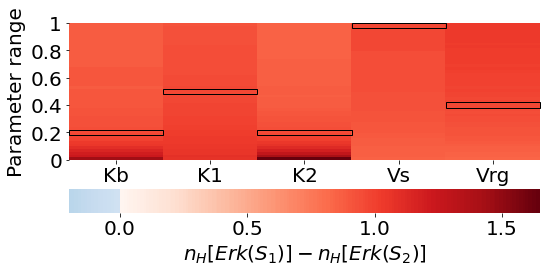

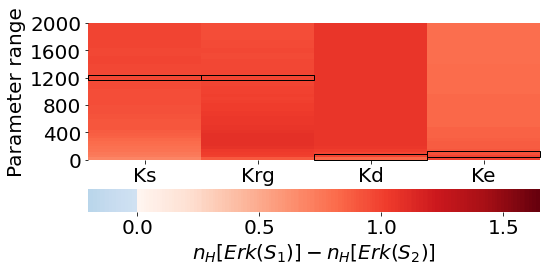

In [33]:
# Load the data 
data_01_6A_load = np.loadtxt('results_01_6A.txt')
data_02000_6A_load = np.loadtxt('results_02000_6A.txt')

# Create the heatmap

# Left panel: Parameters from 0 to 1
Min= -0.2 
Max= max_array(data_01_6A)

fig = plt.figure(figsize=(8,4))
axs = fig.gca()
myHeatmap(data_01_6A,Min,Max, axs, label='$n_H[Erk(S_1)]-n_H[Erk(S_2)]$')

axs.add_patch(Rectangle((0, 9), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((1, 24), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((2, 9), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((3, 48), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((4, 19), 1, 2, fill=False, edgecolor='black', lw=1,clip_on=False))

axs.set_ylabel('Parameter range')
axs.set_xticks([0.5,1.5,2.5,3.5, 4.5])
axs.set_xticklabels(['Kb','K1','K2','Vs', 'Vrg'])
axs.set_yticks([0,10,20, 30, 40, 50])
axs.set_yticklabels(['0','0.2','0.4', '0.6', '0.8', '1'],rotation = 0)
axs.invert_yaxis()
plt.tight_layout()
plt.show()

# Rigth panel: Parameters from 0 to 2000
Min= -0.2
Max= max_array(data_01_6A)

fig = plt.figure(figsize=(8,4))
axs = fig.gca()
myHeatmap(data_02000_6A,Min,Max, axs,label='$n_H[Erk(S_1)]-n_H[Erk(S_2)]$')

axs.add_patch(Rectangle((0, 29), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((1, 29), 1, 2, fill=False, edgecolor='black', lw=1))
axs.add_patch(Rectangle((2, 0), 1, 2, fill=False, edgecolor='black', lw=1, clip_on=False))
axs.add_patch(Rectangle((3, 1), 1, 2, fill=False, edgecolor='black', lw=1, clip_on=False))

axs.set_ylabel('Parameter range')
axs.set_xticks([0.5,1.5,2.5,3.5])
axs.set_xticklabels(['Ks','Krg','Kd','Ke'])
axs.set_yticks([0,10,20, 30, 40, 50])
axs.set_yticklabels(['0','400','800', '1200', '1600', '2000'],rotation = 0)
axs.invert_yaxis()
plt.tight_layout()
plt.show()